In [1]:
#特徴量全使用+全ダミー化
#day+month循環数化
#+category型job/education/contact/poutcome列のunknown多変量補完
#+pdaysを分割
#特徴量16
#スコア：

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
#データ読込
df=pd.read_csv("/content/bank_train.csv")

In [4]:
#dtype確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [5]:
#使用col
use_cols = ["id",
    "age",
    'job',
    'marital',
    'education',
    'default',
    "balance",
    "housing",
    "loan",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    'pdays',
    'previous',
    "poutcome",
     "y"]
df_use = df[use_cols]
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27128 non-null  int64 
 1   age        27128 non-null  int64 
 2   job        27128 non-null  object
 3   marital    27128 non-null  object
 4   education  27128 non-null  object
 5   default    27128 non-null  object
 6   balance    27128 non-null  int64 
 7   housing    27128 non-null  object
 8   loan       27128 non-null  object
 9   contact    27128 non-null  object
 10  day        27128 non-null  int64 
 11  month      27128 non-null  object
 12  duration   27128 non-null  int64 
 13  campaign   27128 non-null  int64 
 14  pdays      27128 non-null  int64 
 15  previous   27128 non-null  int64 
 16  poutcome   27128 non-null  object
 17  y          27128 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [6]:
def data_pre(df):
    #pdaysを接触有とアリならば日数を生成
    df["pdays_yes"]=df["pdays"].apply(lambda x: 0 if x == -1 else 1 if x >= 0 else x)
    df["pdays"]=df["pdays"].apply(lambda x: 0 if x == -1 else  x)

    job_dis = {
    "blue-collar": 0,
    "management": 1,
    "technician": 2,
    "admin.": 3,
    "services": 4,
    "retired": 5,
    "self-employed": 6,
    "entrepreneur": 7,
    "unemployed": 8,
    "housemaid": 9,
    "student": 10,
    "unkown": np.nan
    }
    education_dis={
        "primary": 0,
        "secondary": 1,
        "tertiary": 2,
        "unkown": np.nan
    }
    contact_dis={
        "cellular": 0,
        "telephone": 1,
        "unkown": np.nan
    }
    poutcome_dis={
        "failure": 0,
        "other": 1,
        "success": 2,
        "unkown": np.nan
    }

    df["job"] = df["job"].map(job_dis)
    df["education"] = df["education"].map(education_dis)
    df["contact"] = df["contact"].map(contact_dis)
    df["poutcome"] = df["poutcome"].map(poutcome_dis)

    #月+日の循環数化
    dic={"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}
    df["month"]=df["month"].map(dic).astype(int)
    df["day"]=df["day"].astype(int)

    total_days_in_year = 365  # 仮定として、1年が365日とする
    month_day_number = (df["month"] - 1) * 31 + df["day"]  # 仮定として、1月から12月まで31日とする
    angle = (2 * np.pi * month_day_number) / total_days_in_year

    df["month_day_sin"] = np.sin(angle)
    df["month_day_cos"] = np.cos(angle)

    df = df.drop(columns=['month'], axis=1)
    df = df.drop(columns=['day'], axis=1)

    #marital列のダミー変数化
    dummies_marital=pd.get_dummies(df["marital"], dtype=int,drop_first=True,prefix="marital")
    df = pd.concat([df, dummies_marital], axis=1)
    df.drop(columns=['marital'], inplace=True)

    #default列のダミー変数化+置換
    dummies_default=pd.get_dummies(df["default"], dtype=int,drop_first=True,prefix="default")
    df = pd.concat([df, dummies_default], axis=1)
    df.drop(columns=['default'], inplace=True)

    #housing列のダミー変数化+置換
    dummies_housing=pd.get_dummies(df["housing"], dtype=int,drop_first=True,prefix="housing")
    df = pd.concat([df, dummies_housing], axis=1)
    df.drop(columns=['housing'], inplace=True)

    #loan列のダミー変数化
    dummies_loan=pd.get_dummies(df["loan"], dtype=int,drop_first=True,prefix="loan")
    df = pd.concat([df, dummies_loan], axis=1)
    df.drop(columns=['loan'], inplace=True)

    #多重代入法のインスタンス化と適用
    imputer = IterativeImputer(random_state=0)
    imputed_data = imputer.fit_transform(df)
    df = pd.DataFrame(imputed_data, columns=df.columns)

    df["job"] = np.round(df["job"]).astype(int)
    df["education"] = np.round(df["education"]).astype(int)
    df["contact"] = np.round(df["contact"]).astype(int)
    df["poutcome"] = np.round(df["poutcome"]).astype(int)

    job_dis_inv = {v: k for k, v in job_dis.items()}
    education_dis_inv = {v: k for k, v in education_dis.items()}
    contact_dis_inv = {v: k for k, v in contact_dis.items()}
    poutcome_dis_inv = {v: k for k, v in poutcome_dis.items()}

    df['job'] = df['job'].map(job_dis_inv)
    df["education"] = df["education"].map(education_dis_inv)
    df["contact"] = df["contact"].map(contact_dis_inv)
    df["poutcome"] = df["poutcome"].map( poutcome_dis_inv)

    #job列のダミー変数化
    dummies_job=pd.get_dummies(df["job"], dtype=int,drop_first=True,prefix="job")
    df = pd.concat([df, dummies_job], axis=1)
    df.drop(columns=['job'], inplace=True)

    #education列のダミー変数化
    dummies_education=pd.get_dummies(df["education"], dtype=int,drop_first=True,prefix="education")
    df = pd.concat([df, dummies_education], axis=1)
    df.drop(columns=['education'], inplace=True)

    #contact列のダミー変数化+置換
    dummies_contact=pd.get_dummies(df["contact"], dtype=int,drop_first=True,prefix="contact")
    df = pd.concat([df, dummies_contact], axis=1)
    df.drop(columns=['contact'], inplace=True)

    #poutcome列のダミー変数化+置換
    dummies_poutcome=pd.get_dummies(df["poutcome"], dtype=int,drop_first=True,prefix="poutcome")
    df = pd.concat([df, dummies_poutcome], axis=1)
    df.drop(columns=['poutcome'], inplace=True)

    #IDカテゴリー化
    df["id"]=df["id"].astype("category")

    return df

df_use["y"]=df["y"]
df_use=data_pre(df_use)

In [7]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   27128 non-null  category
 1   age                  27128 non-null  float64 
 2   balance              27128 non-null  float64 
 3   duration             27128 non-null  float64 
 4   campaign             27128 non-null  float64 
 5   pdays                27128 non-null  float64 
 6   previous             27128 non-null  float64 
 7   y                    27128 non-null  float64 
 8   pdays_yes            27128 non-null  float64 
 9   month_day_sin        27128 non-null  float64 
 10  month_day_cos        27128 non-null  float64 
 11  marital_married      27128 non-null  float64 
 12  marital_single       27128 non-null  float64 
 13  default_yes          27128 non-null  float64 
 14  housing_yes          27128 non-null  float64 
 15  loan_yes           

In [8]:
df_use.corr()

,id,age,balance,duration,campaign,pdays,previous,y,pdays_yes,month_day_sin,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_secondary,education_tertiary,contact_telephone,poutcome_other,poutcome_success
id,1.000000,-0.005716,-0.000484,0.002705,0.016867,-0.004526,-0.005425,-0.003555,-0.003968,-0.001468,...,0.002136,-0.003673,0.006958,-0.000358,0.000994,-0.000839,0.001950,0.002645,0.004457,0.009525
age,-0.005716,1.000000,0.095343,-0.005309,-0.001340,-0.025381,0.002946,0.020892,0.006130,-0.121463,...,-0.010758,-0.063262,-0.195871,-0.065798,0.001172,-0.056428,-0.087625,0.172744,-0.013150,0.033808
balance,-0.000484,0.095343,1.000000,0.019923,-0.016295,0.003511,0.012483,0.045826,0.029363,-0.060886,...,0.017235,-0.037678,0.001307,-0.019960,0.009060,-0.075730,0.098151,0.029963,-0.036301,0.031998
duration,0.002705,-0.005309,0.019923,1.000000,-0.087771,0.002006,0.002489,0.401390,0.007820,0.031699,...,0.011423,-0.000821,-0.009369,-0.006484,0.021198,-0.000335,0.003674,-0.017818,-0.045710,0.069363
campaign,0.016867,-0.001340,-0.016295,-0.087771,1.000000,-0.086103,-0.031557,-0.076118,-0.105519,-0.144354,...,0.003895,-0.004189,-0.021345,0.027609,-0.019626,-0.017600,0.011661,0.055935,0.069260,0.042498
pdays,-0.004526,-0.025381,0.003511,0.002006,-0.086103,1.000000,0.421139,0.100632,0.871316,0.166986,...,-0.014427,0.006763,0.025081,-0.006810,-0.006487,0.019661,-0.010223,0.015129,-0.656246,0.173776
previous,-0.005425,0.002946,0.012483,0.002489,-0.031557,0.421139,1.000000,0.083825,0.488211,0.045888,...,-0.002959,-0.011449,0.019321,0.008020,-0.005428,-0.007678,0.022828,0.018798,-0.336571,0.149778
y,-0.003555,0.020892,0.045826,0.401390,-0.076118,0.100632,0.083825,1.000000,0.165010,-0.030973,...,0.004024,-0.024480,0.081543,-0.014855,0.025624,-0.027044,0.063128,0.015431,-0.202658,0.384138
pdays_yes,-0.003968,0.006130,0.029363,0.007820,-0.105519,0.871316,0.488211,0.165010,1.000000,0.105694,...,-0.001323,-0.009630,0.042098,-0.000900,-0.005708,-0.001525,0.028253,0.021677,-0.763509,0.317981
month_day_sin,-0.001468,-0.121463,-0.060886,0.031699,-0.144354,0.166986,0.045888,-0.030973,0.105694,1.000000,...,-0.024142,0.056259,0.006988,-0.083341,0.010224,0.095346,-0.138681,-0.061249,-0.055015,-0.067826


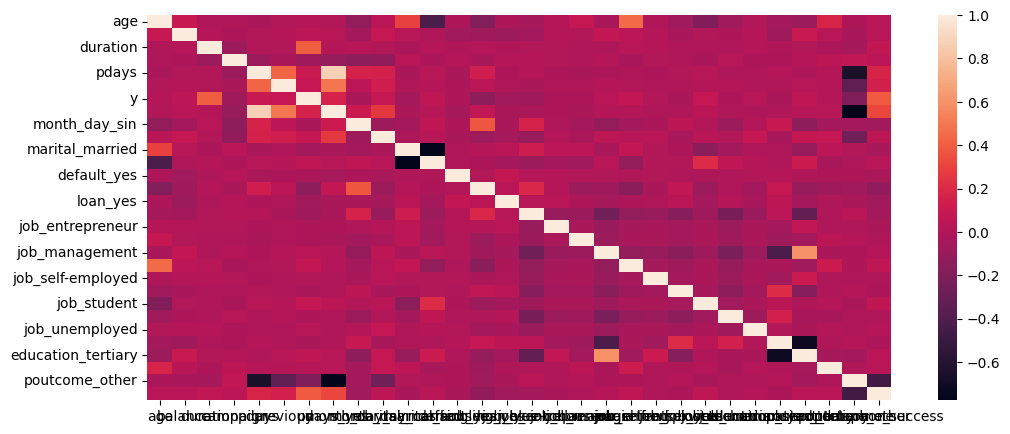

In [9]:
numeric_df = df_use.select_dtypes(include=['number'])
plt.figure(figsize=(12, 5))
sns.heatmap(numeric_df.corr())
plt.xticks(rotation=0)
plt.show()

In [10]:
df_use.describe()

,age,balance,duration,campaign,pdays,previous,y,pdays_yes,month_day_sin,month_day_cos,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,education_secondary,education_tertiary,contact_telephone,poutcome_other,poutcome_success
count,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,...,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000,27128.000000
mean,40.951010,1355.800870,260.711295,2.751769,41.344404,0.579733,0.117001,0.183648,0.117734,-0.430013,...,0.034835,0.093630,0.020532,0.166101,0.029121,0.552381,0.294603,0.062224,0.830286,0.042539
std,10.608542,3003.305272,260.091727,3.126594,100.044906,2.503653,0.321427,0.387204,0.626244,0.639591,...,0.183365,0.291319,0.141815,0.372179,0.168149,0.497258,0.455873,0.241566,0.375388,0.201819
min,18.000000,-6847.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.999991,-0.999963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,104.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.552435,-0.873807,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,39.000000,449.000000,182.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.393590,-0.708627,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,1428.000000,323.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.680773,-0.317191,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,0.999991,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#欠損値確認
df_use.isnull().sum()

id                     0
age                    0
balance                0
duration               0
campaign               0
pdays                  0
previous               0
y                      0
pdays_yes              0
month_day_sin          0
month_day_cos          0
marital_married        0
marital_single         0
default_yes            0
housing_yes            0
loan_yes               0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
education_secondary    0
education_tertiary     0
contact_telephone      0
poutcome_other         0
poutcome_success       0
dtype: int64

In [12]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27128 entries, 0 to 27127
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   27128 non-null  category
 1   age                  27128 non-null  float64 
 2   balance              27128 non-null  float64 
 3   duration             27128 non-null  float64 
 4   campaign             27128 non-null  float64 
 5   pdays                27128 non-null  float64 
 6   previous             27128 non-null  float64 
 7   y                    27128 non-null  float64 
 8   pdays_yes            27128 non-null  float64 
 9   month_day_sin        27128 non-null  float64 
 10  month_day_cos        27128 non-null  float64 
 11  marital_married      27128 non-null  float64 
 12  marital_single       27128 non-null  float64 
 13  default_yes          27128 non-null  float64 
 14  housing_yes          27128 non-null  float64 
 15  loan_yes           

In [13]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae


df_train,df_val =train_test_split(df_use,test_size=0.2,random_state=42)

col = "y"
train_y = df_train[col]
train_x = df_train.drop(col,axis=1)

val_y = df_val[col]
val_x =df_val.drop(col,axis=1)

trains = lgb.Dataset(train_x,train_y)
valids = lgb.Dataset(val_x,val_y)

params = {
    'objective': 'binary',      # 二値分類
    'metric': 'binary_logloss',       # 評価指標：（ロジスティック損失）
    'num_leaves': 31,               # 葉の数
    'learning_rate': 0.1,          # 学習率
    'feature_fraction': 1.0,        # 特徴量のサブサンプル率
    'bagging_fraction': 1.0,        # バギングのサブサンプル率
    'bagging_freq': 5,              # バギングの頻度
    'max_depth': -1,                # ツリーの最大深さ（制限なし）
    'min_data_in_leaf': 1        # 葉の最小データ数
    }

model = lgb.train(
    params,
    trains,
    valid_sets=valids,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100)])

[LightGBM] [Info] Number of positive: 2565, number of negative: 19137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 21702, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.118192 -> initscore=-2.009665
[LightGBM] [Info] Start training from score -2.009665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.182297


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# モデルの予測
pred_y = model.predict(val_x, num_iteration=model.best_iteration)

# 平均二乗誤差（MSE）や平均絶対誤差（MAE）の計算
mse = mean_squared_error(val_y, pred_y)
mae = mean_absolute_error(val_y, pred_y)
print(f'MSE: {mse}, MAE: {mae}')

MSE: 0.056736579421930396, MAE: 0.1115036655728454


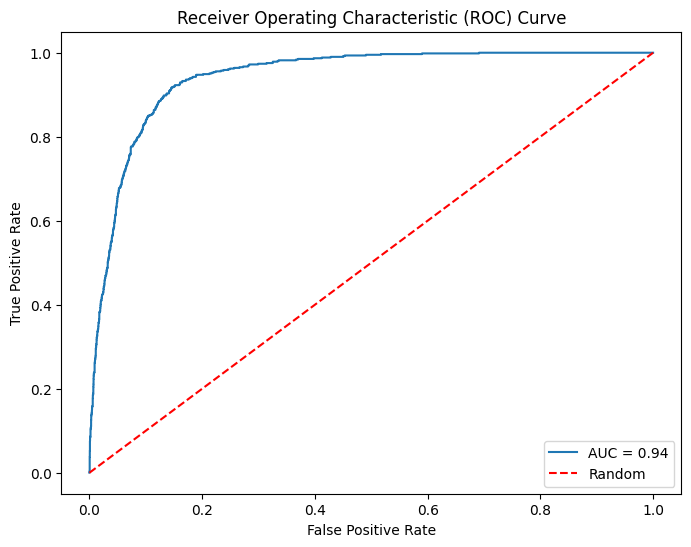

In [15]:
# 予測値から確率に変換する関数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# モデルの予測値を確率に変換
pred_probs = sigmoid(pred_y)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC曲線とAUCの計算
fpr, tpr, thresholds = roc_curve(val_y, pred_probs)
auc = roc_auc_score(val_y, pred_probs)

# ROC曲線のプロット
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [16]:
print(auc)

0.9422643804287838


In [17]:
#データ読み込み
df_test=pd.read_csv("/content/bank_test.csv")

In [18]:
df_test = data_pre(df_test)

In [19]:
predict = model.predict(df_test)
df_test["y"]=predict

In [20]:
df_ID=df_test["id"]
df_test["id"]=df_ID.astype(int)

In [21]:
df_test.to_csv("sample_submit.csv",columns=['id', 'y'],index = False,header = False)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

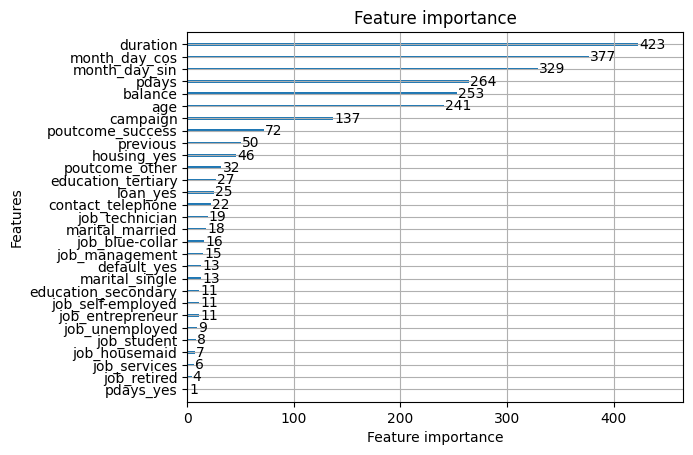

In [22]:
lgb.plot_importance(model)

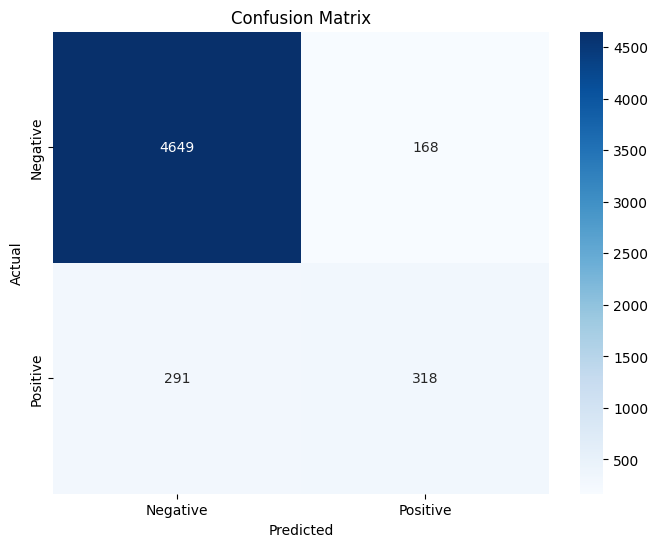

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# 予測（確率）
predict_prob = model.predict(val_x)
# 予測（クラス）
threshold = 0.5
predict_class = (predict_prob >= threshold).astype(int)
# 混同行列
conf_matrix = confusion_matrix(val_y, predict_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# 評価指標
accuracy = accuracy_score(val_y, predict_class)
precision = precision_score(val_y, predict_class)
recall = recall_score(val_y, predict_class)
f1 = f1_score(val_y, predict_class)
roc_auc = roc_auc_score(val_y, predict_prob)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

Accuracy: 0.92
Precision: 0.65
Recall: 0.52
F1 Score: 0.58
ROC AUC: 0.94
